** Example on how to include priors and sample the posterior **

This is mainly motivated by a comment by R. Jeffries, who noticed that the error
on the velocity dispersion is quite small.

The aim of this notebook is therefore to sample the posterior probability, 
determine the errors, and compare them to those obtained by computing the Hessian of the likelihood function.


Here I am NOT sampling on the parallax, which is kept as a fixed value (therefore there might be slight differences
in the estimated parameters).
In the likelihood, I added two additional diagonal terms to the covariance matrix 
to take into account the parallax spread due to the parallax uncertainties.

I also added broad gaussian priors to the parameters, $v_x, v_y, v_z$ and $\sigma_v$. 


The likelihood is below, together with priors (remember to compile it before).

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy import stats
from astropy.io import fits


from pygaia.astrometry.constants import *
_A = auKmYearPerSec  ### km*yr/s

rc('text', usetex= True)
rc('font', family='serif', weight = 'normal', size=15)

In [2]:
hdu = fits.open('Data/vanLeeuwen/ic2602_all.fits')
data2602 = hdu[1].data 

In [6]:
#### Number of stars
N = len(data2602['RA_ICRS']) 

### Coordinates in degree
alpha, delta =  data2602['RA_ICRS'], data2602['DE_ICRS']
positions = np.zeros((N, 2))
positions[:,0], positions[:,1] = alpha, delta 

#### Observables arrays, errors, and correlation coefficients
prlx, pmra, pmdec = data2602['Plx'], data2602['pmRA'], data2602['pmDE']
e_prlx, e_pmra, e_pmdec = data2602['e_Plx'], data2602['e_pmRA'], data2602['e_pmDE']
cc_prlx_pmra, cc_prlx_pmdec, cc_pmra_pmdec = data2602['PlxpmRAcor'], data2602['PlxpmDEcor'], data2602['pmRApmDEcor'] 

#### Define three matrixes, one for the observed quantities, 
#### one for the errors and one for the correlation coefficients

obs = np.transpose(np.array([prlx,pmra,pmdec]))
sigma = np.transpose(np.array([e_prlx, e_pmra, e_pmdec]))
cc = np.transpose(np.array([cc_prlx_pmra, cc_prlx_pmdec, cc_pmra_pmdec]))  


#### Source Id 
gaiaid = data2602['Source']

In [70]:
### Emcee
vx, vy, vz = -11.69, 17.31, -17.45
sigmav = 0.3
p0 = np.array([vx, vy, vz, sigmav])
ndim, nwalkers = 4, 50
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

import emcee
nthreads = 3
sampler = emcee.EnsembleSampler(nwalkers, ndim, totKinPosterior,
                                threads = nthreads, args=(positions, obs, sigma, cc, N))


import time
time0 = time.time()
p = sampler.run_mcmc(pos, 1000)
print('T:', np.round((time.time()-time0)/60., 2))

T: 11.57


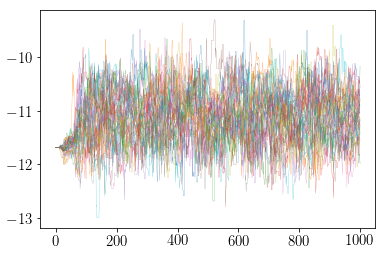

In [73]:
for i in range(36):
    plt.plot(sampler.chain[i, :, 0], '-', lw =0.2)

plt.show()

** Remark **

I have not tested the MCMC with more walkers/steps, as this is just a proof that the errors estimated 
with the Hessian are okay.

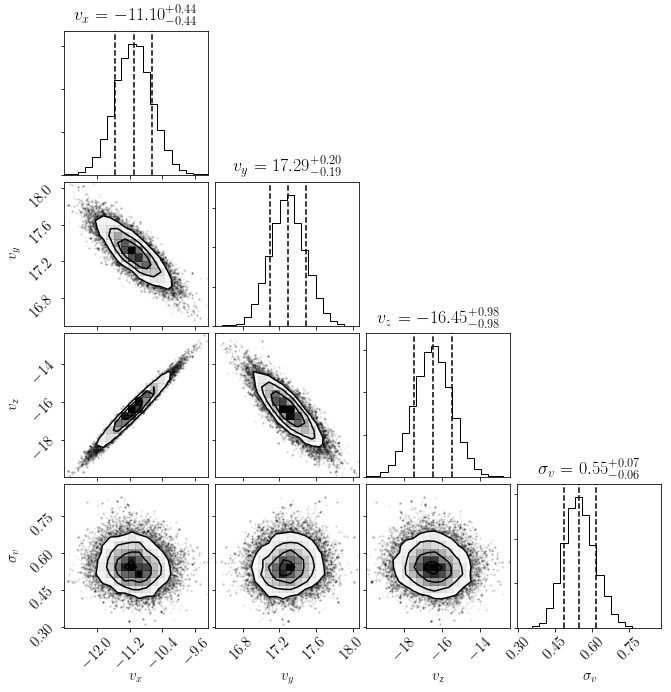

In [72]:
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))

import corner
fig = corner.corner(samples, labels=["$v_x$", "$v_y$", "$v_z$",'$\sigma_v$'],
                    quantiles = [0.16, 0.50, 0.84], show_titles = True, 
                    fontsize = 15)
plt.show()

** Remarks **

The estimated parameters are compatible with those obtained with the maximum likelihood approach,
though the velocity dispersion is larger (however is compatible with the result obtained after the 
first iteration, with no star excluded).

The errors determined with the $16th$ and $84th$ percentile levels are comparable to those determined by
computing the Hessian of the likelihood function. 

From the shape of the posterior distribution, it is evident that the estimated velocities are correlated.
This is quite expected as we actually miss one dimension in our observation set (radial velocity): we are indeed using two measured quantities ($\mu_{\alpha}, \mu_{\delta}$) to determine ($v_x, v_y, v_z$).

### Functions:

In [65]:
def kinLikelihood(paramsK, positions, obsK, errorsK, covK, k = 3):
    '''
    Parameters:
    -------------
    positions - RA, DEC in deg;
    paramsK - Model parameters. In order: [parallax, vx, vy, vz, sigmav];
    obsK - Observed quantities. In order: [parallax, pmRA, pmDE];
    errorsK- Errors on obs. quantities.In order: [e_prlx, e_pmRA, e_pmDE];
    covK- Terms of covariance matrix. In order: [prlx_pmRA, prlx_pmDE, pmRA_pmDE]
        
    Returns:
    log(kinematic likelihood), kinematic likelihood
    '''
    
    
    #### Convert RA & DEC from deg to rad:
    ra, dec = positions
    deg2rad = np.pi/180.
    ra = ra*deg2rad
    dec = dec*deg2rad
    
    #### Model parameters for Kinematic
    prlx_mod = obsK[0]                                                  ### Parallax;
    vx, vy, vz, sigmav = paramsK[0], paramsK[1], paramsK[2], paramsK[3] ### 3 velocity components 
    v = np.array([vx, vy, vz])                                          ### + velocity dispersion;       
    
    
    #print(prlx_mod, v)
    #### Define the normal triad:
    from pygaia.astrometry.vectorastrometry import normalTriad
    p, q, r = normalTriad(ra, dec)
    pmRA_mod = np.dot(np.transpose(p),v)*prlx_mod/_A
    pmDE_mod = np.dot(np.transpose(q),v)*prlx_mod/_A
    
    
    #### Explicit obs:
    prlx = obsK[0]
    pmRA, pmDE = obsK[1], obsK[2]
   
    
    #### Errors and covariance terms
    e_prlx = errorsK[0]
    e_pmRA, e_pmDE = errorsK[1], errorsK[2]
    prlxpmRA, prlxpmDE, pmRApmDE = covK[0], covK[1], covK[2]
    
    #### Covariance Matrix
    covM = np.zeros((k,k), dtype=np.float64)
    covM[0,0], covM[1,1], covM[2,2]  = e_prlx**2., e_pmRA**2., e_pmDE**2.
    covM[0,1] = e_prlx*e_pmRA*prlxpmRA
    covM[1,0] = covM[0,1]
    covM[0,2] = e_prlx*e_pmDE*prlxpmDE
    covM[2,0] = covM[0,2]
    covM[1,2] = e_pmRA*e_pmDE*pmRApmDE
    covM[2,1] = covM[1,2]
    
    #### Write dispersion matrix.
    
    ### This term takes into account the spread due to the velocity dispersion;
    dispM = np.zeros((k,k), dtype=np.float64)
    dispM[1,1] = (sigmav*prlx/_A)**2
    dispM[2,2] = (sigmav*prlx/_A)**2
    
    ### This term is the dispersion due to a parallax spread;
    dispM2 = np.zeros((k,k), dtype=np.float64)
    dispM2[1,1] = (np.dot(np.transpose(p),v)*e_prlx/_A)**2
    dispM2[2,2] = (np.dot(np.transpose(q),v)*e_prlx/_A)**2
    
    
    
    
    #### Add up the matrixes:
    totdispM = np.add(dispM, dispM2)
    totM =  np.add(covM,totdispM)
    invM =  np.ones((k,k))
    
    detM, invM = det_inv_3(totM)
    
    
    #### Define the array of difference between the observed and modelled values:
    
    a_c = np.array([prlx - prlx_mod, pmRA - pmRA_mod,
                    pmDE - pmDE_mod])
    #### Define the chi-square function
    g = np.dot(np.dot(a_c, invM), a_c)
    

    #### Finally define the likelihood:
    like = ((2*np.pi)**(-k/2)*detM**(-0.5))*np.exp(-0.5*g)
    logLike =  -(k/2.)*np.log(2*np.pi) - 0.5*np.log(detM) - 0.5*g  
    ### Return Log-Likelihood
    return logLike


def velxPrior(vx, vxcentre, sigmav, vxmax, vxmin):
    
    '''
    Prior on the velocity along the x direction.
    It is just a flat prior, but adding the limits makes it a proper prior.
    
    Parameters:
    -----------
    vx - velocity along the x axis;
    
    Returns:
    ----------
    log(prior) if the parameter is in the right range,
    -np.inf otherwise.
    '''
    
    if   (vxmin < vx < vxmax):
        prior = stats.norm.pdf(vx, loc = vxcentre, scale = sigmav)
        return np.log(prior)
    
    
    else:
        return - np.inf
    
    

def velyPrior(vy, vycentre, sigmav, vymax, vymin):
    
    
    if (vymin < vy < vymax):
        prior = stats.norm.pdf(vy, loc = vycentre, scale = sigmav)
        return np.log(prior)
    
    else: 
        return -np.inf

def velzPrior(vz, vzcentre, sigmav,  vzmax, vzmin):
    
    '''
    Prior on the velocity along the z direction.
    It is just a flat prior, but adding the limits makes it a proper prior.
    
    Parameters:
    -----------
    vz - velocity along the z axis;
    
    Returns:
    ----------
    log(prior) if the parameter is in the right range,
    -np.inf otherwise.
    '''
    
    if   (vzmin < vz < vzmax):
        prior = stats.norm.pdf(vz, loc = vzcentre, scale = sigmav)
        return np.log(prior)
    
    
    else:
        return - np.inf
    
    
    
def sigmavPrior(sigma, sigmamax, sigmamin):
    
    '''
    Same as the other priors on velocity.
    
    '''

    if   (sigmamin < sigma < sigmamax):
        return 0.
    
    else:
        return -np.inf

        
def kinPosterior(paramsK, positions, obsK, errorsK, covK, k = 3):
    
    '''
    Returns the log(kinetic posterior).
    Same input parameters as kinLikelihood.
    
    vxmax, vymax... and vxmin, vymin, ecc might be changing according to necessity.
    
    '''
    
    logLike = kinLikelihood(paramsK, positions, obsK, errorsK, covK, k = 3)
    
    vxmin, vxmax = -100, 100.
    vymin, vymax = -100., 100.
    vzmin, vzmax = -100., 100.
    
    sigmamin, sigmamax = 0., 1.
    
    sigmavcentre = 10.  ### This changes according to the group
    vxcentre = -11.69
    
    sigmavcentre = 10.
    vycentre = 17.31
    
    sigmavcentre = 10. 
    vzcentre = -17.45
    
    
    
    velxP = velxPrior(paramsK[0],vxcentre, sigmavcentre,  vxmax ,vxmin)
    velyP = velyPrior(paramsK[1], vycentre, sigmavcentre, vymax, vymin)
    velzP = velzPrior(paramsK[2], vzcentre, sigmavcentre, vzmax, vzmin)
    sigmavP = sigmavPrior(paramsK[3], sigmamax = sigmamax, sigmamin = sigmamin)
    
    return logLike + velxP + velyP+ velzP + sigmavP
    
    
def totKinPosterior(paramsK, positions, obsK, errorsK, covK, N, k = 3):
    '''
    Returns totPost, the kinematic posterior for the cluster (N stars) 
    Same arguments as other functions + N = number of stars.
    
    
    '''
    
    
    totPost = 0.
    for i in range(N):
        post = kinPosterior(paramsK, positions[i], obsK[i], errorsK[i], covK[i], k = 3)
        totPost += post
    
    
    return totPost

In [11]:
def det_inv_3(A):
    '''
    Determinant of a 3x3 matrix.
    If A > (3,3) then choose the first three components.
    Parameters:
    ------------
    A: matrix
    
    Returns:
    det: determinant of A
    
    '''
    
    if len(A) > 3:
        mat = A[:3,:3]
        
    else:
        mat = A
    
    a = mat[0,0]
    b = mat[0,1]
    c = mat[0,2]
    d = mat[1,0]
    e = mat[1,1]
    f = mat[1,2]
    g = mat[2,0]
    h = mat[2,1]
    i = mat[2,2]

    det = b*f*g + c*d*h + a*e*i - a*f*h - b*d*i - c*e*g

    invmat = np.zeros((3,3))
    invmat[0,0] = (e*i - f*h) / det
    invmat[0,1] = (c*h - b*i) / det
    invmat[0,2] = (b*f - c*e) / det
    invmat[1,0] = (f*g - d*i) / det
    invmat[1,1] = (a*i - c*g) / det
    invmat[1,2] = (c*d - a*f) / det
    invmat[2,0] = (d*h - e*g) / det
    invmat[2,1] = (b*g - a*h) / det
    invmat[2,2] = (a*e - b*d) / det

    
    
    return det, invmat

def det_inv_2(A):
    '''
    Determinant of a 2x2 matrix.
    If A > (2,2) then choose the last two components.
    Parameters:
    ------------
    A: matrix
    
    Returns:
    detA: determinant of A
    
    '''
    
    if len(A) > 2:
        mat = A[-2:,-2:]
        
    else:
        mat = A
        
    a = mat[0,0]
    b = mat[0,1]
    c = mat[1,0]
    d = mat[1,1]
    
    det = a*d-b*c
    
    invmat = np.zeros((2,2))
    invmat[0,0] = d/det
    invmat[1,1] = a/det
    invmat[0,1] = -b/det
    invmat[1,0] = -c/det
    
    return  det, invmat
    
    

    